# Python-libraries Course Project 



**План проекта**
* [Введение](#intro)
* [1. Загрузка данных](#load)
* [2. EDA](#eda)
* [3. Очистка данных(выбросы и пропуски)](#outlier)
* [4. Feature engineering](#feature)
* [5. Отбор признаков](#feature_selection)
* [6. Разбиение на train и test](#split)
* [7. Построение модели](#modeling)
* [8. Прогнозирование на тестовом датасете](#prediction)

### Введение <a class='anchor' id='intro'>

За основу курсового проекта был взят предложенный компанией "Geekbrains" Baseline расположенный по ссылке - https://www.kaggle.com/julichitai/baseline  ;  В качестве основной модели был использован LGBMRegressor

Score baseline'а : 0.7

Score моего проекта : ~0.734

Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)
В процессе работы пробовал разную логику обработки данных, создания фич. Пробовал моодели RandomForestRegressor, LGBMRegressor и CatBoostRegressor. Пробовал разбивать выборку на кластеры с помощью TSNE + K-means, выделять 2 кластера и делать 2 модели для каждого кластера а после обьединять предсказания по обоим кластерам. В работе оставил самый адекватный , с моей точки зрения, вариант.

**Подключение библиотек и скриптов**

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета и подбор гиперпараметров
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

# 3. Нормализация данных 
from sklearn.preprocessing import StandardScaler

# 4. Модели 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# 5. Метрики качества
from sklearn.metrics import r2_score as r2


import datetime
import gc # сборщик мусора


In [2]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [3]:
# Функция визуализация скор метрики r2
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [4]:
TRAIN_DATASET_PATH = '../input/real-estate-price-prediction-moscow/train.csv'
TEST_DATASET_PATH = '../input/real-estate-price-prediction-moscow/test.csv'

### 1. Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [5]:
# Подгружаем train data в df_train и test data в X_test
df_train = pd.read_csv(TRAIN_DATASET_PATH)
X_test = pd.read_csv(TEST_DATASET_PATH)



# Для df_train и X_test в качества индекса устанавливаем колонку 'Id'
df_train.set_index('Id', inplace=True)
X_test.set_index('Id', inplace=True)

# Смотрим на количество строк в данных
print('Строк в трейне:', df_train.shape[0])
print('Строк в тесте', X_test.shape[0])

# Удаляем df_train чтобы не занимал место


Строк в трейне: 10000
Строк в тесте 5000


In [6]:
df_train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


### Приведение типов

In [7]:
df_train.dtypes

DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [8]:
df_train['DistrictId'] =df_train['DistrictId'].astype(str)
X_test['DistrictId'] = X_test['DistrictId'].astype(str)

## 2. EDA  <a class='anchor' id='eda'>
Делаем EDA для:
- Исправления выбросов
- Заполнения NaN
- Идей для генерации новых фич

**Матрица корреляции**

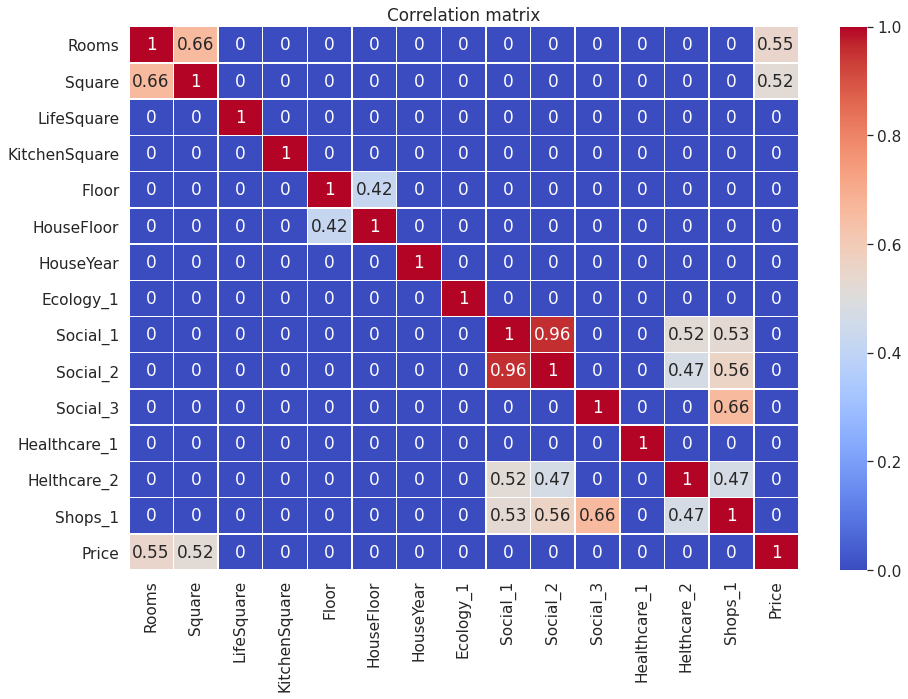

In [9]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

По матрице корреляции можно сделать вледующие выводы : 
* Ожидаемо площадь и количество комнат неплохо коррелируют, в рамках разумного
* Этажность здания и этажность квартиры имеют небольшую корреляцию, на первый взляд - бесполезно 
* Social_1, Shops_1 и Healthcare_2 хорошо коррелируют, думаю речь здесь идет о районах, может стоит выделить их в кластеры и использовать как фичу ?
* Social_1 и Social_2 сильно коррелируют, возможно, имеет смысл выкинуть Social_2
* Social_3 коррелирует с Shops_1, что это мне дает... пока не знаю

**Гистограммы по колличественным признакам**

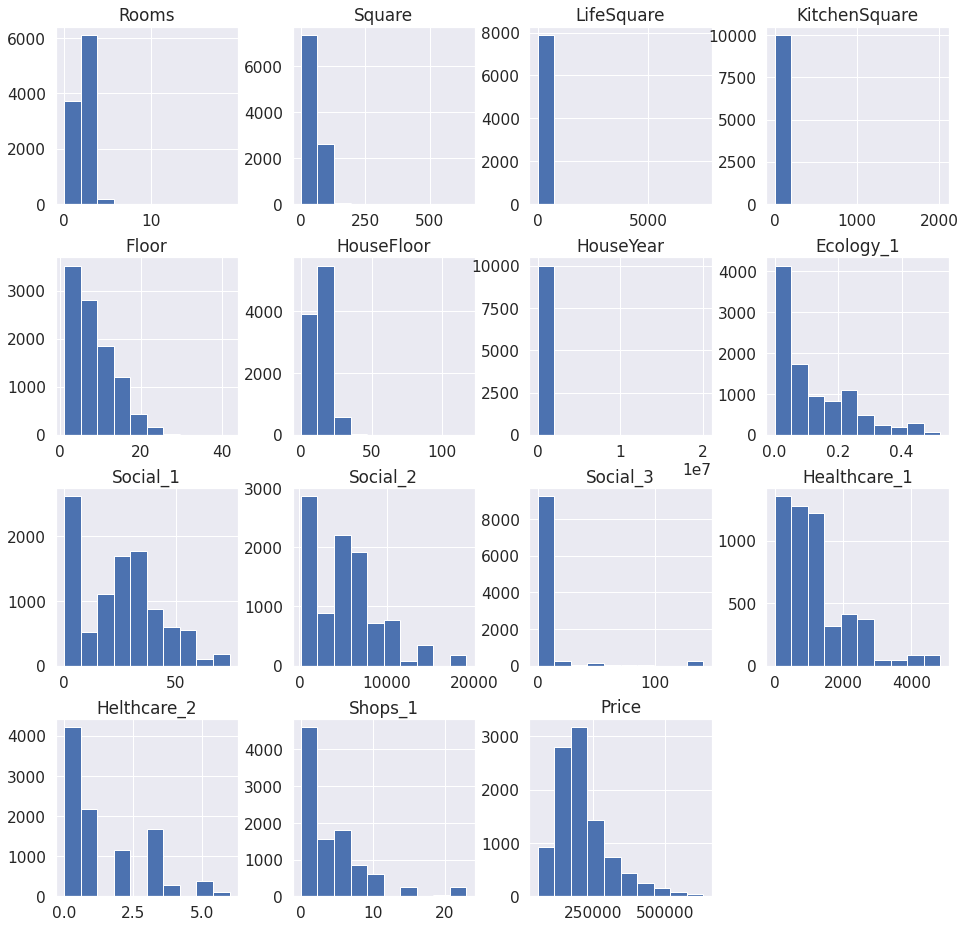

In [10]:
# Делю имеющиеся признаки на категориальные и колличественные 
num_features = list(df_train.select_dtypes(exclude='object').columns)
cat_features = list(df_train.select_dtypes(include='object').columns)

# Создаю гистограммы по кол. признакам 
df_train[num_features].hist( figsize=(16,16), bins=10)

plt.show()

Выводы по гистограмме:

* Rooms, Square, LifeSquare, KitchenSquare, Floor, HouseFloor, HouseYear, Social_3 - имеют сильные выбросы
* Shops_1, Healthcare_2 - имеют странное распределение

**Пропуски**

In [11]:
# Смотрим где есть пропуски и создаем список таких колонок
nan_features = df_train.columns[df_train.isna().any()].tolist()
  
# Cмотрим сколько процентов значений пропущено во всех столбцах
    
for el in nan_features:
    print('В столбце', el, 'пропущенно', df_train[el].isnull().sum() * 100 / len(df_train), '% значений')

В столбце LifeSquare пропущенно 21.13 % значений
В столбце Healthcare_1 пропущенно 47.98 % значений


Выводы по выбросам : 
* Думаю что LifeSquare довольно важный показатель и можно провести какую-то логическую корреляцию с параметром Square, попробую его обработать 
* Показатель  Healthcare_1 мне не до конца понятен и пропусков ~50% , выкидываю его.

**Выбросы**

In [12]:
# Rooms

df_train['Rooms'].value_counts().sort_index()

# Думаю, если > 6 комнат, то сделаю значение = 5 комнатам.
# А если 0 то пусть будет 1

0.0        8
1.0     3705
2.0     3880
3.0     2235
4.0      150
5.0       18
6.0        1
10.0       2
19.0       1
Name: Rooms, dtype: int64

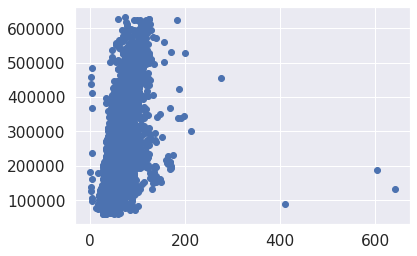

False    9994
True        6
Name: Square, dtype: int64

In [13]:
# Square

plt.scatter(df_train['Square'], df_train['Price'])

plt.show()

(df_train['Square'] > 200).value_counts()

# Возможно, стоит выкинуть значения больше 200 


In [14]:
#feature_importances.sort_values(by='importance', ascending=False).head()

In [15]:
#plt.scatter(X_train['Square'], y_train)

#plt.show()

In [16]:
lf_df = df_train[df_train['LifeSquare'] < 50]
lf_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6697 entries, 3013 to 7202
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   DistrictId     6697 non-null   object 
 1   Rooms          6697 non-null   float64
 2   Square         6697 non-null   float64
 3   LifeSquare     6697 non-null   float64
 4   KitchenSquare  6697 non-null   float64
 5   Floor          6697 non-null   int64  
 6   HouseFloor     6697 non-null   float64
 7   HouseYear      6697 non-null   int64  
 8   Ecology_1      6697 non-null   float64
 9   Ecology_2      6697 non-null   object 
 10  Ecology_3      6697 non-null   object 
 11  Social_1       6697 non-null   int64  
 12  Social_2       6697 non-null   int64  
 13  Social_3       6697 non-null   int64  
 14  Healthcare_1   3884 non-null   float64
 15  Helthcare_2    6697 non-null   int64  
 16  Shops_1        6697 non-null   int64  
 17  Shops_2        6697 non-null   object 
 18  Price

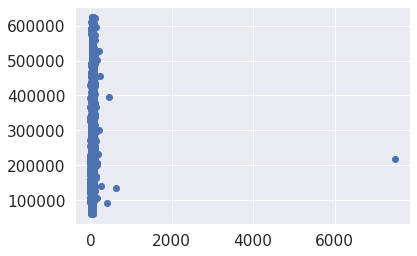

False    9992
True        8
Name: LifeSquare, dtype: int64

In [17]:
plt.scatter(df_train['LifeSquare'], df_train['Price'])

plt.show()

(df_train['LifeSquare'] > 200).value_counts()

# Возможно, стоит выкинуть значения больше 200
# Также, при боле детальном рассмотрении бросается в глаза множество значений < 10 метров самых разных ценовых категории
# может стоит заменить их медианой?

In [18]:
# KitchenSquare

df_train['KitchenSquare'].value_counts().sort_index()

# По закону РФ, площадь кухни не может быть  < 3, так что в качестве минимальной площади установлю эту
# Площадь > 20 также кажется сомнительной, эти значения нужно либо выкинуть, либо сделать равными 20 

0.0        697
1.0       2460
2.0          4
3.0         22
4.0         39
5.0       1169
6.0       1038
7.0        609
8.0       1306
9.0        843
10.0      1075
11.0       233
12.0       249
13.0        67
14.0        51
15.0        31
16.0        16
17.0        12
18.0         6
19.0        11
20.0        14
21.0         1
22.0         3
23.0         1
25.0         2
26.0         1
27.0         1
29.0         1
30.0         2
31.0         1
32.0         2
35.0         1
36.0         1
37.0         2
39.0         1
40.0         1
41.0         2
42.0         1
43.0         2
48.0         1
51.0         2
53.0         1
54.0         1
58.0         2
60.0         1
62.0         1
63.0         1
66.0         1
72.0         1
73.0         1
75.0         1
78.0         1
84.0         1
96.0         1
112.0        2
123.0        1
1970.0       1
2014.0       1
Name: KitchenSquare, dtype: int64

In [19]:
#HouseFloor

df_train['HouseFloor'].value_counts().sort_index()
# Полагаю, здании в котором 0 этажей у нас нет, стоит 0 этажей заменить на 1 этаж

0.0       269
1.0       497
2.0        48
3.0       127
4.0       134
5.0      1031
6.0        58
7.0        59
8.0       141
9.0      1389
10.0      135
11.0       28
12.0     1074
13.0       27
14.0      625
15.0      123
16.0      576
17.0     2331
18.0       89
19.0      108
20.0      105
21.0       33
22.0      343
23.0       40
24.0      176
25.0      374
26.0        1
27.0        6
28.0        3
29.0        1
30.0       21
31.0        1
32.0        4
36.0        1
37.0        4
38.0        1
39.0        2
40.0        7
44.0        1
45.0        1
47.0        1
48.0        2
99.0        2
117.0       1
Name: HouseFloor, dtype: int64

In [20]:
# Floor

df_train['Floor'].value_counts().sort_index()

# Тут вроде бы все ок, есть выбросы но они по крайней мере логичны, 42+ этажные здания в Москве существуют

1     235
2     588
3     872
4     949
5     876
6     802
7     759
8     643
9     604
10    553
11    457
12    438
13    398
14    362
15    287
16    290
17    256
18    185
19    121
20     68
21     59
22     54
23     25
24     53
25     34
26     18
27      5
28      3
31      1
32      2
33      1
37      1
42      1
Name: Floor, dtype: int64

In [21]:
# В данных много ошибок, может ли быть такое, что квартира расположена на этаже, который выше чем заявлено в здании?
(df_train['Floor'] > df_train['HouseFloor']).sum()

# Таких случаев довольно много, замен в этом случае Floor на HouseFloor, 
                                # тогда квартира будет на самом высоком этаже в здании

1825

In [22]:
# HouseYear

df_train[df_train['HouseYear'] > 2021].head()

# В списке есть дома, построенные в будущем, это надо обработать

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
Id,,,,,,,,,,,,,,,,,,,
11607,147,2.0,44.791836,28.360393,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B,243028.603096
10814,109,1.0,37.265070,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B,254084.534396


**Категориальные переменные**

In [23]:
#Смотрим на то, какие есть категориальные переменные
df_train.select_dtypes(include='object').columns.tolist()

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [24]:
# DistrictId
df_train['DistrictId'].value_counts()
# Подразумевается 209 районов

27     851
1      652
23     565
6      511
9      294
      ... 
205      1
117      1
196      1
207      1
209      1
Name: DistrictId, Length: 205, dtype: int64

In [25]:
# Ecology_2

df_train['Ecology_2'].value_counts()
# Можно засунуть в dummy переменную 

B    9903
A      97
Name: Ecology_2, dtype: int64

In [26]:
# Ecology_3

df_train['Ecology_3'].value_counts()
# Можно засунуть в dummy переменную 

B    9725
A     275
Name: Ecology_3, dtype: int64

In [27]:
# Shops_2

df_train['Shops_2'].value_counts()
# Можно засунуть в dummy переменную 

B    9175
A     825
Name: Shops_2, dtype: int64

### 3. Очистка данных(выбросы и пропуски)  <a class='anchor' id='outlier'>
Что можно делать с выбросами?
1. Выкинуть эти данные (только на трейне, на тесте ничего не выкидываем)
2. Заменять выбросы разными методами (медианы, средние значения, np.clip и т.д.)
3. Делать/не делать дополнительную фичу
4. Ничего не делать

In [28]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms'] # !!! медиана посчитана на трейне !!!
        
        
        # Square !
#         X.loc[(X['Square'] > 110) & (X['Square'] < 1000), 'Square'] =  X.loc[X['Square'] > 300, 'Square'] * 0.2
#         X.loc[(X['Square'] > 110) & (X['Square'] < 1000), 'Square'] =  X.loc[X['Square'] > 300, 'Square'] * 0.2
        X.loc[(X['Square'] < 20), 'Square'] =  X.loc[(X['Square'] < 20), 'Square'] * 2 + 20
        X.loc[(X['Square'] > 250), 'Square'] =  self.medians['Square']
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] / 10  # можно median
        X.loc[X['KitchenSquare'] >= 21, 'KitchenSquare']  = 20 # !!!


        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
          
        
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        # X.loc[(X['LifeSquare'] > 200), 'LifeSquare'] =  self.medians['LifeSquare']
        # X.loc[(X['LifeSquare'] < 10), 'LifeSquare'] =  self.medians['LifeSquare']
        return X

### 4. Feature engineering  <a class='anchor' id='feature'>

In [29]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  ## Если вы этого не сделаете, то на Leaderboard-е улетите в самый низ (>100 места, R2 ~ 0.65),
                                            ## Хотя на локальной валидации скор вырастет
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X

### 5. Отбор признаков  <a class='anchor' id='feature_selection'>

In [30]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictId_count',
                     'new_district', 'floor_cat', 'year_cat',  'MedPriceByDistrict', 'MedPriceByFloorYear']

target_name = 'Price'

### 6. Разбиение на train и test  <a class='anchor' id='split'>

In [31]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True)

In [33]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 22), (3300, 22), (5000, 22))

In [34]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 28), (3300, 28), (5000, 28))

In [35]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [36]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### 7. Построение моделей  <a class='anchor' id='modeling'>

**LGBMRegressor**

In [37]:
# Заранее, с помощью GridSearchCV получил лучшие гиперпараметры
lgbm = LGBMRegressor(max_depth=20,
                             num_leaves=31,
                             n_estimators=500,
                             learning_rate=0.03)

lgbm.fit(X_train, y_train)


LGBMRegressor(learning_rate=0.03, max_depth=20, n_estimators=500)

Train R2:	0.894
Test R2:	0.754


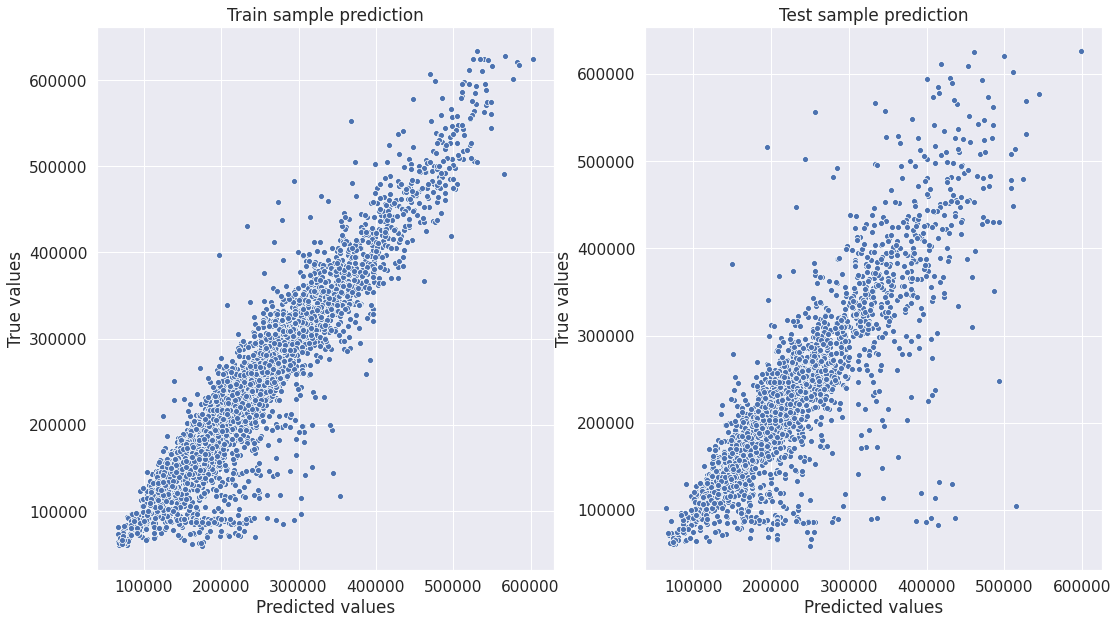

In [38]:
y_train_preds = lgbm.predict(X_train)
y_valid_preds = lgbm.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [39]:
# cv_score
cv_score = cross_val_score(lgbm, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))

mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.710 +- 0.015


Train R2:	0.894
Test R2:	0.754


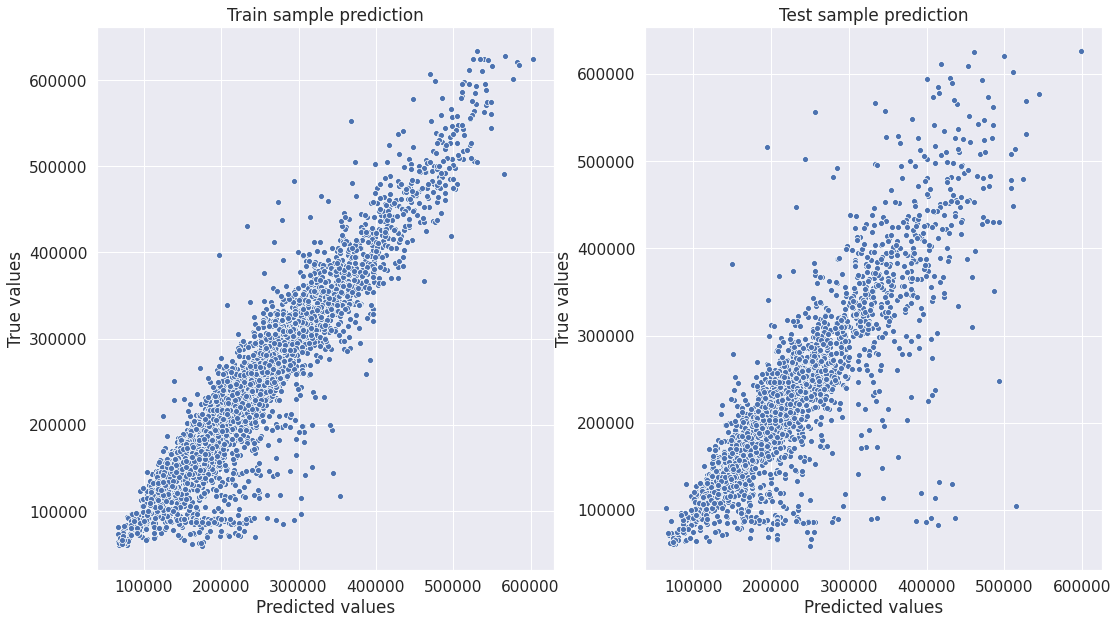

In [40]:
y_train_preds = lgbm.predict(X_train)
y_valid_preds = lgbm.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

**Важность признаков**

In [41]:
feature_importances = pd.DataFrame(zip(X_train.columns, lgbm.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,2151
2,LifeSquare,1638
6,HouseYear,1573
7,Ecology_1,1281
12,Social_3,996
24,MedPriceByDistrict,924
4,Floor,871
5,HouseFloor,866
3,KitchenSquare,864
11,Social_2,862


### 8. Прогнозирование на тестовом датасете  <a class='anchor' id='prediction'>

1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Не потерять и не перемешать индексы от примеров при построении прогнозов
3. Прогнозы должны быть для все примеров из тестового датасета (для всех строк)

In [42]:
test_df.shape

(5000, 26)

In [43]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rooms                5000 non-null   float64
 1   Square               5000 non-null   float64
 2   LifeSquare           5000 non-null   float64
 3   KitchenSquare        5000 non-null   float64
 4   Floor                5000 non-null   float64
 5   HouseFloor           5000 non-null   float64
 6   HouseYear            5000 non-null   int64  
 7   Ecology_1            5000 non-null   float64
 8   Ecology_2            5000 non-null   int64  
 9   Ecology_3            5000 non-null   int64  
 10  Social_1             5000 non-null   int64  
 11  Social_2             5000 non-null   int64  
 12  Social_3             5000 non-null   int64  
 13  Helthcare_2          5000 non-null   int64  
 14  Shops_1              5000 non-null   int64  
 15  Shops_2              5000 non-null   i

In [44]:
submit = pd.read_csv('/kaggle/input/real-estate-price-prediction-moscow/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [46]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rooms                5000 non-null   float64
 1   Square               5000 non-null   float64
 2   LifeSquare           5000 non-null   float64
 3   KitchenSquare        5000 non-null   float64
 4   Floor                5000 non-null   float64
 5   HouseFloor           5000 non-null   float64
 6   HouseYear            5000 non-null   int64  
 7   Ecology_1            5000 non-null   float64
 8   Ecology_2            5000 non-null   int64  
 9   Ecology_3            5000 non-null   int64  
 10  Social_1             5000 non-null   int64  
 11  Social_2             5000 non-null   int64  
 12  Social_3             5000 non-null   int64  
 13  Helthcare_2          5000 non-null   int64  
 14  Shops_1              5000 non-null   int64  
 15  Shops_2              5000 non-null   i

In [47]:
predictions = lgbm.predict(test_df)
predictions

array([165840.71962583, 126163.96329933, 149857.08704334, ...,
       145851.5375351 , 199696.85107919, 234461.40858799])

In [48]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,165840.719626
1,5925,126163.963299
2,960,149857.087043
3,3848,112331.864569
4,746,171391.030721


In [49]:
submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5000 non-null   int64  
 1   Price   5000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 78.2 KB


In [50]:
submit.to_csv('submission.csv', index=False)


In [51]:
submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      5000 non-null   int64  
 1   Price   5000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 78.2 KB
